<a href="https://colab.research.google.com/github/yashpatil454/Retail-Shop-Sales-Prediction-Regression/blob/main/Rossmann_Sales_Prediction_2_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#Importing ML libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import pickle
#Importing metrics for model evaluation.
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#Mounting drive
from google.colab import drive
drive.mount('/content/gdrive')
#The default figure size to 8 inches by 5 inches and the figure resolution (dots per inch) to 100.
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':100})
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
#For hosted runtime
#Importing all the cleaned and splitted data
X_train = pd.read_csv('/content/gdrive/MyDrive/Retail Sales Prediction/traintestdata/X_train.csv', parse_dates=['Date'])
X_test = pd.read_csv('/content/gdrive/MyDrive/Retail Sales Prediction/traintestdata/X_test.csv', parse_dates=['Date'])
y_train = pd.read_csv('/content/gdrive/MyDrive/Retail Sales Prediction/traintestdata/y_train.csv')
y_test = pd.read_csv('/content/gdrive/MyDrive/Retail Sales Prediction/traintestdata/y_test.csv')
comparison_df = pd.read_csv('/content/gdrive/MyDrive/Retail Sales Prediction/traintestdata/comparison_df.csv', index_col=0)

#For local runtime
# X_train = pd.read_csv('C:/Users/yash.patil/Documents/Python/Retail_Sales_Prediction_Project/X_train.csv', parse_dates=['Date'])
# X_test = pd.read_csv('C:/Users/yash.patil/Documents/Python/Retail_Sales_Prediction_Project/X_test.csv', parse_dates=['Date'])
# y_train = pd.read_csv('C:/Users/yash.patil/Documents/Python/Retail_Sales_Prediction_Project/y_train.csv')
# y_test = pd.read_csv('C:/Users/yash.patil/Documents/Python/Retail_Sales_Prediction_Project/y_test.csv')
# comparison_df = pd.read_csv('C:/Users/yash.patil/Documents/Python/Retail_Sales_Prediction_Project/comparison_df.csv')

In [25]:
#Setting date and store as index
X_train.set_index(['Date','Store'],inplace=True)
X_test.set_index(['Date','Store'],inplace=True)
y_train.set_index(['Date','Store'],inplace=True)
y_test.set_index(['Date','Store'],inplace=True)

In [26]:
#Scaling the data for better model predictions.
from sklearn.preprocessing import StandardScaler

#Scaling the train and test data.
scale = StandardScaler()
X_train[list(X_train.columns)] = scale.fit_transform(X_train[list(X_train.columns)])
X_test[list(X_test.columns)] = scale.transform(X_test[list(X_test.columns)])

scaler = StandardScaler()
y_train[list(y_train.columns)] = scaler.fit_transform(y_train[list(y_train.columns)])
y_test[list(y_test.columns)] = scaler.transform(y_test[list(y_train.columns)])

In [27]:
#Creating a method for model evaluation that gives us the calculated metrics.
def model_eval(model, model_name):
  #making predictions
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  #Calculating metrices
  #Mean Absolute Error
  MAE_train = round(mean_absolute_error(y_train,y_pred_train),4)
  MAE_test = round(mean_absolute_error(y_test,y_pred_test),4) 
  #Mean Squared Error 
  MSE_train = round(mean_squared_error(y_train,y_pred_train),4)
  MSE_test = round(mean_squared_error(y_test,y_pred_test),4)
  #Root Mean Squared Error 
  RMSE_train = round(mean_squared_error(y_train,y_pred_train,squared=False),6)
  RMSE_test = round(mean_squared_error(y_test,y_pred_test,squared=False),6)
  #R2
  R2_train = round(r2_score(y_train, y_pred_train),6)
  R2_test = round(r2_score(y_test, y_pred_test),6)
  #Adjusted R2
  n1 = len(y_train)
  n2 = len(y_test)
  k1 = X_train.shape[1]
  k2 = X_test.shape[1]
  Adj_r2_train = round(1 - (1-R2_train) * (n1-1) / (n1-k1-1), 4)
  Adj_r2_test = round(1 - (1-R2_test) * (n2-1) / (n2-k2-1), 4)

  #Printing the results
  print(f'The Mean Absolute Error for the validation set is {MAE_test}')
  print(f'The Mean Squared Error for the validation set is {MSE_test}')
  print(f'The Root Mean Squared Error for the validation set is {RMSE_test}')
  print(f'The R^2 for the validation set is {R2_test}')
  print(f'The Adjusted R^2 for the validation set is {Adj_r2_test}')

  #plotting the predictions
  y_true = y_test.copy()
  y_true['Pred Sales'] = y_pred_test.tolist()
  df_plot = y_true.reset_index(level=['Date']).groupby('Date')['Sales','Pred Sales'].sum()
  ax = sns.lineplot(data=df_plot)
  ax.xaxis.set_major_locator(plt.MaxNLocator(10))
  # sns.lineplot(data = df_plot)
  plt.ylabel("Total Sales and Predicted Sales")
  plt.xticks(rotation = 15)

  #Saving our results
  metric_scores = [model_name,MAE_train,MSE_train,RMSE_train,R2_train,Adj_r2_train,MAE_test,MSE_test,RMSE_test,R2_test,Adj_r2_test]
  return metric_scores

###Note: 
Random Forest Hyperparamater Tuning and fitting to the dataset was taking large amount of RAM and the session was getting crashed. Therefore, Hyperparameter Tuning XGB Regressor because it is an ensemble learning method for gradient boosting decision trees.

###XGBoost (eXtreme Gradient Boosting) Hyperparameter Tuning

XGBoost (eXtreme Gradient Boosting) is designed to be highly efficient and flexible, and is particularly useful for large-scale datasets and high-dimensional problems.

The XGBoost algorithm is based on the idea of boosting, which is a technique that combines several weak learners to create a single, powerful model. The weak learners in XGBoost are decision trees, and the algorithm iteratively adds new trees to the ensemble, each one correcting the errors of the previous trees.

In [28]:
#Initializing XGBRegressor for hyperparameter tuning.
xgb = XGBRegressor(tree_method='gpu_hist')

In [29]:
# Define the parameter distribution for the hyperparameter search
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(1, 11),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 2),
}

print(param_dist)

{'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd33d2a0130>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd33d250640>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd365a47940>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd365a47d90>, 'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd33d261c40>}


In [30]:
#Feeding the param_grid to the model
XGB_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=20, cv=3, random_state=42, n_jobs=-1)
#Fit the random search model
XGB_random_search.fit(X_train,y_train)
XGB_random_search.best_params_

[09:45:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'colsample_bytree': 0.645614570099021,
 'learning_rate': 0.1323705789444759,
 'max_depth': 10,
 'reg_alpha': 0.09333132642723085,
 'subsample': 0.9868777594207296}

In [31]:
comparison_df

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,Decision Tree Regressor,0.0000,0.0000,0.0011,1.0000,1.0000,0.1982,0.0748,0.2735,0.9206,0.9206
1,Random Forest Regressor,0.0472,0.0041,0.0640,0.9959,0.9959,0.1576,0.0446,0.2111,0.9527,0.9527


The Mean Absolute Error for the validation set is 0.1568
The Mean Squared Error for the validation set is 0.042
The Root Mean Squared Error for the validation set is 0.204906
The R^2 for the validation set is 0.955427
The Adjusted R^2 for the validation set is 0.9554


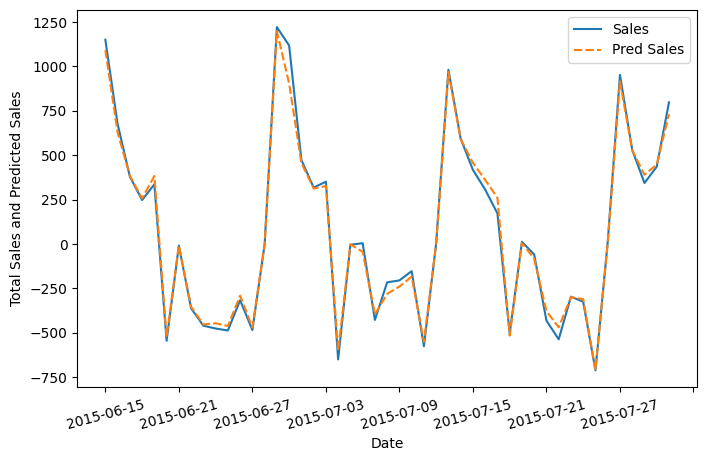

In [32]:
#Evaluating the trained model 
XGBRegressor_tuned = model_eval(XGB_random_search, 'XGBRegressor Tuned')
#Saving the evaluated metrics onto the comparison_df
comparison_df = comparison_df.append(pd.DataFrame([XGBRegressor_tuned], columns=comparison_df.columns), ignore_index=True)

###Pickling the model :) 

In [33]:
#Saving the trained Decesion Tree Regressor model on the drive
pickle.dump(XGB_random_search, open("/content/gdrive/MyDrive/Retail Sales Prediction/XGBRegressor_Tuned_Model.pkl", "wb"))

In [34]:
#Our final comparison_df
comparison_df

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,Decision Tree Regressor,0.0000,0.0000,0.001100,1.000000,1.0000,0.1982,0.0748,0.273500,0.920600,0.9206
1,Random Forest Regressor,0.0472,0.0041,0.064000,0.995900,0.9959,0.1576,0.0446,0.211100,0.952700,0.9527
2,XGBRegressor Tuned,0.1237,0.0266,0.163118,0.973392,0.9734,0.1568,0.0420,0.204906,0.955427,0.9554


In [35]:
#Saving final comparison_df to drive
comparison_df.to_csv('/content/gdrive/MyDrive/Retail Sales Prediction/traintestdata/comparison_df.csv')

###Model Improvement  

In [45]:
# Calculate the improvement of the last model over the previous model
XGB_over_RF = (comparison_df['Test_R2'].iloc[-1] - comparison_df['Test_R2'].iloc[-2]) / comparison_df['Test_R2'].iloc[-2]
# Print the improvement percentage
print("The XGB Regressor Tuned model has improved the Test_R2 score by {:.2f} % over the Random Forest model.".format(XGB_over_RF*100))

The XGB Regressor Tuned model has improved the Test_R2 score by 0.29 % over the Random Forest model.


In [47]:
# Calculate the improvement of the last model over the previous model
RF_over_DT = (comparison_df['Test_R2'].iloc[-2] - comparison_df['Test_R2'].iloc[-3]) / comparison_df['Test_R2'].iloc[-3]
# Print the improvement percentage
print("The Random Forest model has improved the Test_R2 score by {:.2f} % over the Decision Tree model.".format(RF_over_DT*100))

The Random Forest model has improved the Test_R2 score by 3.49 % over the Decision Tree model.


###Visualizing improvements that we achieved model after model.

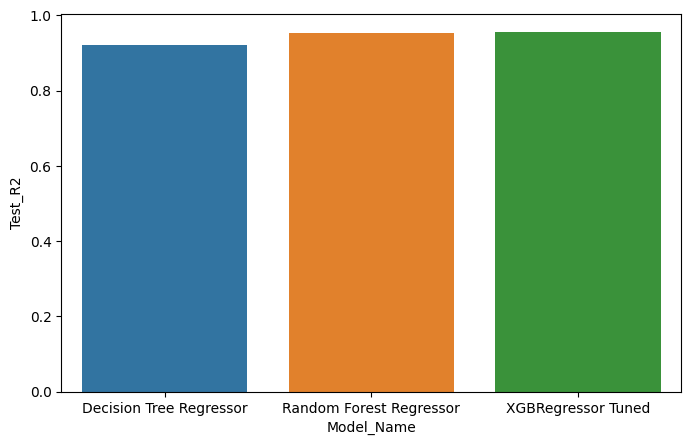

In [36]:
#Visualising our comparison_df for Test_R2
sns.barplot(x = comparison_df['Model_Name'], y = comparison_df['Test_R2'])

Observation: 

In this case, the Random Forest model has a Test_R2 score of 0.9527, which is 3.49% higher than the Decision Tree model's score of 0.920600. This suggests that the Random Forest model is able to make better predictions than the Decision Tree model.

On the other hand, the XGB Regressor Tuned model has a Test_R2 score of 0.955427, which is 0.29% higher than the Random Forest model's score of 0.9527. This suggests that the XGB Regressor Tuned model is able to make slightly better predictions than the Random Forest model. However, the difference is small and may not be significant for all use cases. Therefore, it would be necessary to analyze other performance metrics and evaluate the trade-offs between the different models to determine which one is best suited for a particular task.






###Predictions of sales by store.

In [37]:
#Making predictions to determine the store sales
y_pred_test = XGB_random_search.predict(X_test)
store_sales = y_test.copy()
store_sales['Pred_Sales'] = y_pred_test.tolist()

In [38]:
#inverse_transforming the sales and predicited sales column
store_sales[store_sales.columns.tolist()] = scaler.inverse_transform(store_sales[store_sales.columns.tolist()])

In [39]:
#Inversing the Logarithmic transformation made on the dataset in part 1 so that we get originl sales values
store_sales[store_sales.columns.tolist()] = np.exp(store_sales[store_sales.columns.tolist()])

In [40]:
#sales vs predictions
store_sales.head()

Sales    Pred_Sales
Date       Store                       
2015-06-15 1       5518.0   5543.550942
           2       8106.0   7800.246175
           3      10818.0  11461.877968
           4      12398.0  12559.878484
           5       7808.0   7687.400060

In [41]:
#Checking the expected sales. 
store_sales.loc[('2015-07-28',50)]

Sales         5115.000000
Pred_Sales    5208.090634
Name: (2015-07-28, 50), dtype: float64

##Conclusion and Recommendations
**Conclusion**

Companies use sales predictions to estimate their future revenue, which allows them to make informed decisions and strategic business plans. These plans, such as budgets, hiring, incentives, goals, acquisitions, and growth strategies, are heavily dependent on the projected revenue for the upcoming months. Therefore, accurate sales forecasts are crucial for the success of these plans.

This study aims to predict the sales of various Rossmann stores across Europe for the past six weeks, and compares the outcomes of the developed models with the actual sales figures.

The analysis yielded several key findings, including:
* A higher number of sales were observed on Mondays, likely due to many stores being closed on Sundays and resulting in the lowest sales for that day.
* The positive impact of promotions on customer and sales numbers was evident.
* Most stores had competition distances within 0-10km, and these stores had higher sales than stores located further away, potentially indicating more competition in busier locations.
* Despite having fewer stores, store type B had the highest sales average, likely due to having all three types of assortments, particularly assortment level B, and being open on Sundays.
* The Random Forest Tuned Model produced the almost same results as compared to basic Random Forest Model, suggesting that the model captured all relevant trends and patterns without overfitting and achieved the maximum level of performance possible.

**Recommendations**
* More stores should be encouraged to participate in promotions.
* The number of store type B should be increased.
* To take advantage of seasonal trends, stores should be encouraged to promote during holidays.
